In [111]:
import sys
if not sys.argv[1] == "-f":
    path = sys.argv[1]
    IF = "01"
    mode = "commandline"
else:
    # 手動で解析する場合はデータのあるpathを指定してください
    path = "/home/amigos/hdd/data/observation/otf_planet2018/n20190928012625_12CO_2-1_otfplanet_jupiter"
    path = "/home/amigos/hdd/data/observation/otf_planet2018/n20191001142537_12CO_2-1_otfplanet_sun"
    path2 = "/home/amigos/hdd/data/observation/otf_planet2018/n20191001144255_12CO_2-1_otfplanet_sun"
    path2 = "/home/amigos/hdd/data/observation/otf_planet2018/n20191001150019_12CO_2-1_otfplanet_sun"
    mode = "notebook"

In [112]:
import necstdb
import numpy
import matplotlib.pyplot as plt
import os
import pandas
from datetime import datetime as dt
from astropy.coordinates import get_body, AltAz, EarthLocation, SkyCoord
import astropy.units as u
from datetime import datetime as dt
from astropy.time import Time
nanten2 = EarthLocation(lat = -22.96995611*u.deg, lon = -67.70308139*u.deg, height = 4863.85*u.m)
import kisa_rev
import calc_coord
from numpy import deg2rad

In [113]:
import sys
sys.path.append("/home/amigos/git/analy_n2data/script")

In [114]:
# iflist = ["01","02","03","04","05","06","07","08","09","10","11","12","13","14","15","16"]
import make_dset
IF = "01"
d, data, total_p = make_dset.get_data(path, IF)
d = numpy.array(d)
data = numpy.array(data)
xffts_data = data.T[2:].T

100%|██████████| 4/4 [00:00<00:00, 285.00it/s]


 0.0
 1.0
 3.0
 4.0
 5.0
 6.0
 7.0
 8.0
 9.0
9.0 OFF 0.0 0.0
9.0 ON 0.0 0.0


In [115]:
n = necstdb.opendb(path)

In [116]:
nn = n.open_table("status_encoder")

In [117]:
enc = nn.read()
enc = numpy.array(enc)

In [118]:
enc_az = enc.T[1].astype(numpy.float64)
enc_el = enc.T[2].astype(numpy.float64)
enc_time = enc.T[4].astype(numpy.float64)

In [119]:
dtime_list = [dt.utcfromtimestamp(i) for i in enc_time]

In [120]:
target_list = get_body("sun", Time(dtime_list))

In [121]:
target_list.location = nanten2

In [122]:
planet_az = target_list.altaz.az.deg
planet_el = target_list.altaz.alt.deg

In [123]:
dd2 = [kisa_rev.apply_kisa_test(deg2rad(planet_az[i]), deg2rad(planet_el[i]), "/home/amigos/ros/src/necst/lib/hosei_230.txt") for i in range(len(planet_az))]

In [124]:
dd2 = numpy.array(dd2)

In [125]:
hosei_planet_az = planet_az - dd2.T[0]/3600
hosei_planet_el = planet_el - dd2.T[1]/3600

<IPython.core.display.Javascript object>


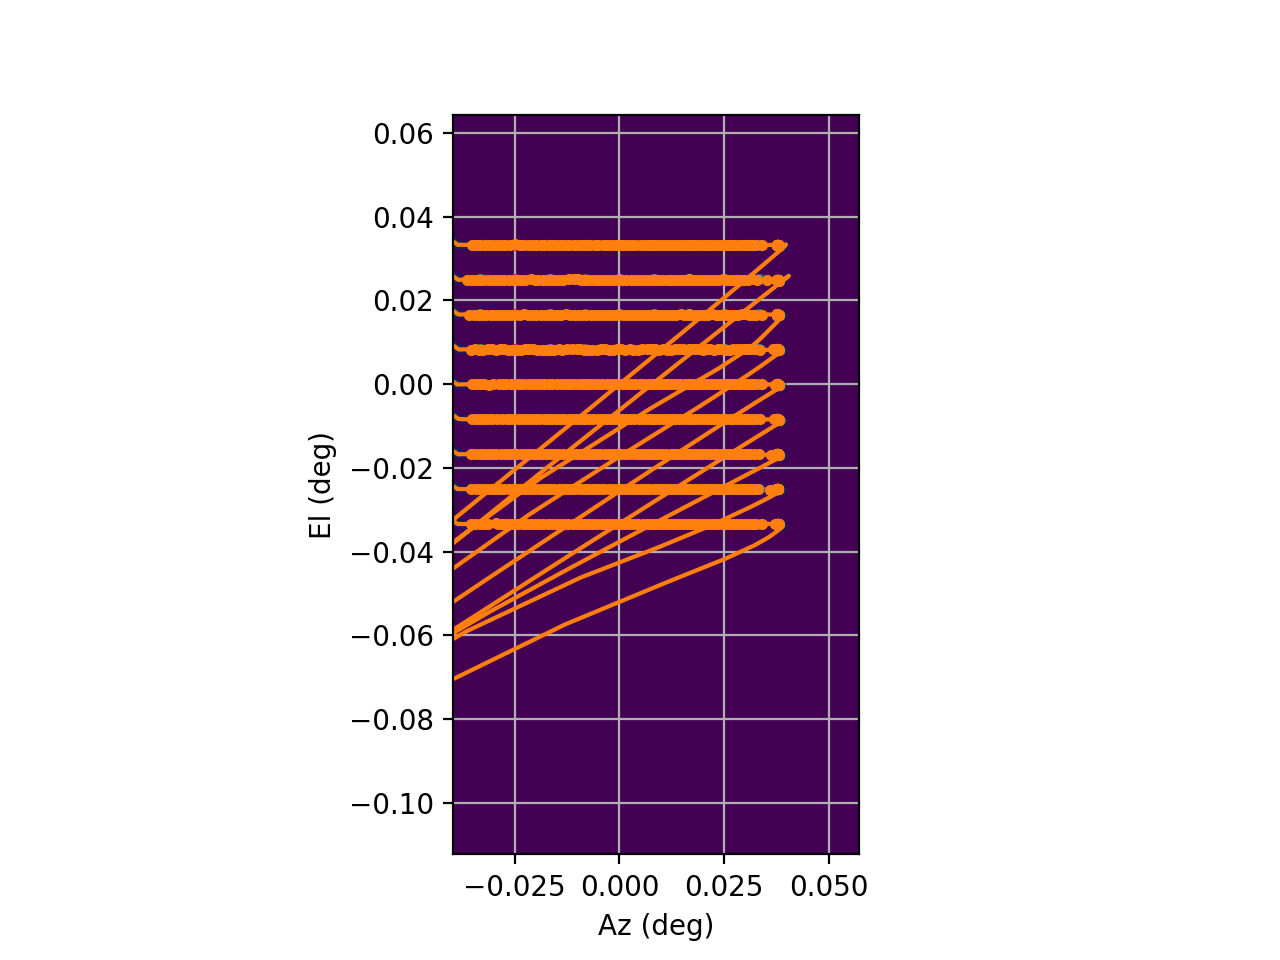

In [126]:
%matplotlib notebook
plt.plot(hosei_planet_az - enc_az/3600, hosei_planet_el - enc_el/3600, ".", alpha=0.01)
plt.plot(hosei_planet_az- enc_az/3600, hosei_planet_el - enc_el/3600)
plt.grid()
plt.xlabel("Az (deg)")
plt.ylabel("El (deg)")
plt.show()

In [127]:
obs_mode = d.T[0]

In [128]:
hotmask = obs_mode == "HOT"
offmask = obs_mode == "OFF"
onmask = obs_mode == "ON"

In [129]:
def chopper_wheel(on, off, hot, temprature = 300):
    Tastar = temprature * (on - off)/(hot - off)
    return Tastar

In [130]:
lamda_on = 0
grid = 30
beta_on = 0
N=9

In [131]:
azgrid = numpy.arange(lamda_on - ((N-1)/2)*grid, lamda_on + ((N-1)/2+1)*grid, grid)
elgrid = numpy.arange(beta_on - ((N-1)/2)*grid, beta_on + ((N-1)/2+1)*grid, grid)
azel_grid = numpy.meshgrid(azgrid, elgrid)

In [132]:
azel_grid[0] = azel_grid[0]/3600
azel_grid[1] = azel_grid[1]/3600

In [133]:
plt.plot(azel_grid[0], azel_grid[1], ".")
plt.show()

In [134]:
xffts_timestamp = total_p.T[1]

In [135]:
index = []
for i in range(len(xffts_timestamp)):
    try:
        a = numpy.where(enc_time > xffts_timestamp[i])
        #print(a)
        index.append(a[0][0])
    except Exception as e:
        print(e)

In [136]:
diff_enc_az = enc_az[1:] - enc_az[:-1]
diff_enc_el = enc_el[1:] - enc_el[:-1]
diff_time = enc_time[1:] - enc_time[:-1]

In [137]:
xffts_az = []
xffts_el = []
xffts_time = []

In [138]:
planet_offsetaz = hosei_planet_az - enc_az/3600
planet_offsetel = hosei_planet_el - enc_el/3600

In [139]:
diff_az = planet_offsetaz[1:] - planet_offsetaz[:-1]
diff_el = planet_offsetel[1:] - planet_offsetel[:-1]
diff_time = enc_time[1:] - enc_time[:-1]

In [140]:
xffts_az = []
xffts_el = []
xffts_time = []

In [141]:
for n,i in enumerate(index):
    try:
        xffts_az.append((diff_az[i]/diff_time[i]) * (xffts_timestamp[n] - enc_time[i-1]) + planet_offsetaz[i-1])
        xffts_el.append((diff_el[i]/diff_time[i]) * (xffts_timestamp[n] - enc_time[i-1]) + planet_offsetel[i-1])
        xffts_time.append(xffts_timestamp[n])
    except Exception as e:
        print(e, i)

In [142]:
xffts_az = numpy.array(xffts_az)
xffts_el = numpy.array(xffts_el)
plt.plot(xffts_az[onmask], xffts_el[onmask], ".")
plt.show()

In [143]:
from tqdm import tqdm
max_scannum = 9
offset = 30

In [156]:
%time
index_list = []
for i in tqdm(range(max_scannum)):
    tmp = []
    for j in range(max_scannum):
       # print(ragrid[i], decgrid[j])
        index1 = numpy.where((azgrid[i]-(offset)<xffts_az[onmask]*3600) & ((azgrid[i] + (offset)>xffts_az[onmask]*3600)))
        index2 = numpy.where((elgrid[j]-(offset)<xffts_el[onmask]*3600) & ((elgrid[j] + (offset)>xffts_el[onmask]*3600)))
        index_ = [i in index2[0] for i in index1[0]]
        index_ = numpy.array(index_)
        index_1and2 = numpy.where(index_ == True)
        index_1and2 = index1[0][index_1and2]
        tmp.append(index_1and2)
    index_list.append(tmp)
print(index_1and2)

100%|██████████| 9/9 [00:00<00:00, 152.09it/s]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 12.4 µs
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50 156]


In [149]:
#off integration
off = []
scanmasks = numpy.unique(d.T[1])
for i in scanmasks:
    scanmask = d.T[1] == i
    mask = numpy.logical_and(offmask, scanmask)
    off.append(numpy.mean(total_p[mask]))

/home/amigos/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/amigos/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [150]:
#hot integration
hot = []
scanmasks = numpy.unique(d.T[1])
for i in scanmasks:
    scanmask = d.T[1] == i
    mask = numpy.logical_and(hotmask, scanmask)
    hot.append(numpy.mean(total_p[mask]))

/home/amigos/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/amigos/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [153]:
hot
off

[nan,
 1046626648.3221157,
 1046626676.5925337,
 1046626704.8539187,
 1046626733.3073404,
 1046626761.8093785,
 1046626791.418656,
 1046626819.811626,
 1046626848.450611,
 1046626876.921718,
 nan]

In [158]:
index_list

[[array([ 899,  900,  901,  902,  903,  904,  905,  906,  907,  908,  909,
         1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023]),
  array([ 785,  786,  787,  788,  789,  790,  791,  792,  793,  794,  795,
          899,  900,  901,  902,  903,  904,  905,  906,  907,  908,  909,
         1018]),
  array([671, 672, 675, 676, 677, 678, 679, 680, 681, 785, 786, 787, 788,
         789, 790, 791, 792, 793, 794, 795]),
  array([559, 560, 563, 564, 565, 566, 567, 568, 671, 672, 673, 674, 675,
         676, 677, 678, 679, 680, 681]),
  array([444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 559, 560,
         561, 562, 563, 564, 565, 566, 567, 568, 673, 674]),
  array([330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 444, 445,
         446, 447, 448, 449, 450, 451, 452, 453, 454, 561, 562]),
  array([215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 330,
         331, 332, 333, 334, 335, 336, 337, 338, 339, 340]),
  array([103, 104, 105, 106, 107, 10

In [171]:
_d = numpy.zeros((9, 9))
for i in range(9):
    for j in range(9):
        on = numpy.mean(total_p[index_list[i][j]])
        print(on , off[i], hot[i])
        _d[i][j] = Tastar = chopper_wheel(on , off[i], hot[i])

1046626674.02 nan nan
1046626668.87 nan nan
1046626663.29 nan nan
1046626657.97 nan nan
1046626652.63 nan nan
1046626647.22 nan nan
1046626640.9 nan nan
1046626635.75 nan nan
1046626632.75 nan nan
1046626673.76 1046626648.32 1046626639.55
1046626668.5 1046626648.32 1046626639.55
1046626662.91 1046626648.32 1046626639.55
1046626657.34 1046626648.32 1046626639.55
1046626652.34 1046626648.32 1046626639.55
1046626646.66 1046626648.32 1046626639.55
1046626640.91 1046626648.32 1046626639.55
1046626635.23 1046626648.32 1046626639.55
1046626632.78 1046626648.32 1046626639.55
1046626673.28 1046626676.59 1046626667.88
1046626667.83 1046626676.59 1046626667.88
1046626662.42 1046626676.59 1046626667.88
1046626656.8 1046626676.59 1046626667.88
1046626651.58 1046626676.59 1046626667.88
1046626645.86 1046626676.59 1046626667.88
1046626641.2 1046626676.59 1046626667.88
1046626634.83 1046626676.59 1046626667.88
1046626632.91 1046626676.59 1046626667.88
1046626673.06 1046626704.85 1046626696.11
10466266

<IPython.core.display.Javascript object>


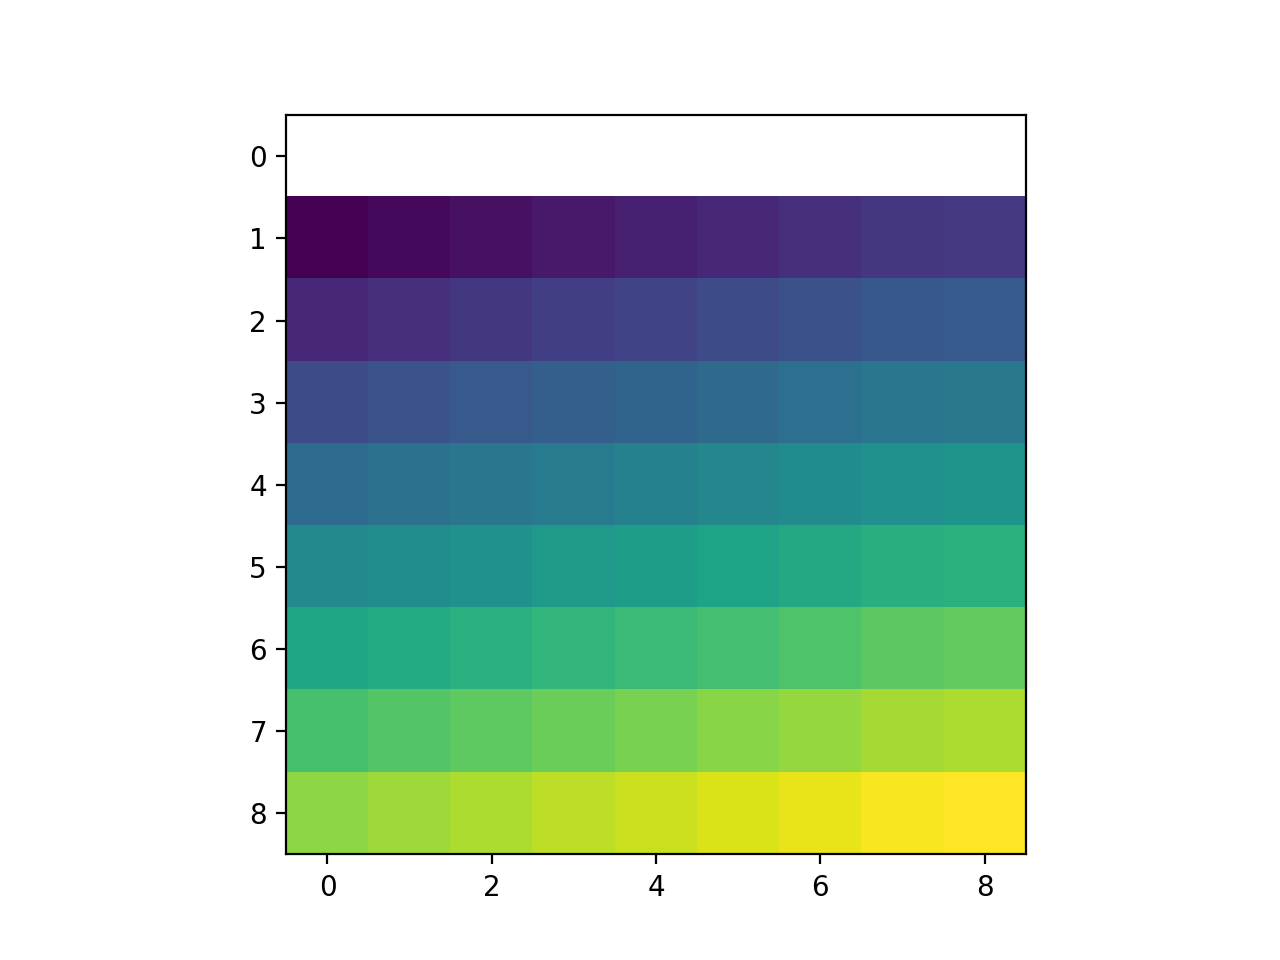

In [172]:
plt.imshow(_d)
plt.show()

In [168]:
_d

array([[-879.43344962, -703.04470015, -512.12959077, -330.07410153,
        -147.51333436,   37.73480274,  254.01500174,  430.100334  ,
         532.70139907],
       [-870.38330448, -690.4802035 , -499.12980888, -308.61147019,
        -137.52769227,   56.70695655,  253.68080798,  448.12289768,
         531.68607887],
       [-853.92603324, -667.54606152, -482.29864642, -289.93736146,
        -111.41764699,   84.14612861,  243.62016819,  461.71584912,
         527.47966902],
       [-846.47899349, -654.33081931, -473.41015465, -278.21754546,
         -96.54028348,   98.15498156,  265.1087587 ,  475.73946421,
         549.58202836],
       [-831.99211484, -639.42424561, -459.72575464, -264.98028445,
         -83.51208682,  114.6150388 ,  292.83367337,  489.21620308,
         583.33933432],
       [-814.93572678, -629.21323107, -437.59543331, -261.32923121,
         -65.61541126,  118.50877605,  307.51223954,  504.38621506,
         598.50337047],
       [-803.04351315, -613.83560689, -4